In [1]:
import os
import glob
import numpy as np
import string
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import CTCLoss
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [2]:
characters = string.ascii_letters + string.digits
char_to_idx = {char: idx + 1 for idx, char in enumerate(characters)}
char_to_idx['<BLANK>'] = 0
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
class ReceiptDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.image_files = glob.glob(os.path.join(images_dir, '*.jpg'))
        self.transform = transform

        self.samples = []

        for img_path in self.image_files:
            txt_path = img_path.replace('.jpg', '.txt')
            if not os.path.exists(txt_path):
                continue  # Skip if annotation file does not exist

            try:
                with open(txt_path, 'r', encoding='utf-8') as f:
                    lines = f.readlines()
            except UnicodeDecodeError as e:
                print(f"Error reading file {txt_path}: {e}")
                continue  # Skip this file or handle it as needed

            for line in lines:
                # Process each line as before
                line = line.strip()
                if not line:
                    continue  # Skip empty lines
                parts = line.strip().split(',')
                if len(parts) < 9:
                    continue  # Invalid annotation format
                coords = list(map(int, parts[:8]))
                transcript = ','.join(parts[8:]).strip()
                self.samples.append({
                    'image_path': img_path,
                    'coords': coords,
                    'transcript': transcript
                })


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = cv2.imread(sample['image_path'])
        if img is None:
            raise FileNotFoundError(f"Image not found: {sample['image_path']}")

        # Coordinates of the bounding box
        coords = sample['coords']
        pts = np.array(coords, dtype='float32').reshape(4, 2)

        # Calculate width and height of the cropped image
        width = int(max(np.linalg.norm(pts[0] - pts[1]), np.linalg.norm(pts[2] - pts[3])))
        height = int(max(np.linalg.norm(pts[0] - pts[3]), np.linalg.norm(pts[1] - pts[2])))

        # Destination points for the perspective transform
        dst_pts = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype='float32')

        # Compute the perspective transform matrix
        M = cv2.getPerspectiveTransform(pts, dst_pts)

        # Perform the perspective transform
        warped = cv2.warpPerspective(img, M, (width, height))

        # Convert to PIL Image
        cropped_img = Image.fromarray(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

        if self.transform:
            cropped_img = self.transform(cropped_img)

        # Encode the transcript
        transcript = sample['transcript']
        label = [char_to_idx[char] for char in transcript if char in char_to_idx]

        return cropped_img, torch.tensor(label, dtype=torch.long)

In [5]:
train_images_dir = 'dataset/train'
test_images_dir = 'dataset/test'

train_dataset = ReceiptDataset(images_dir=train_images_dir, transform=transform)
test_dataset = ReceiptDataset(images_dir=test_images_dir, transform=transform)

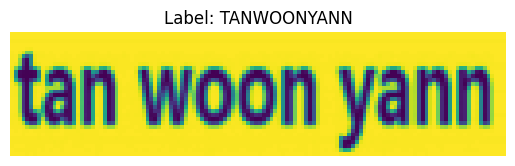

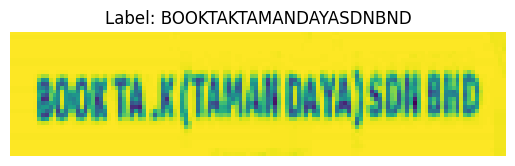

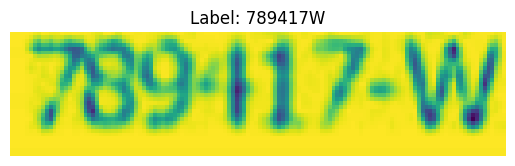

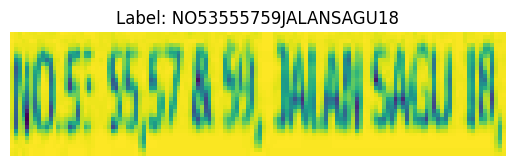

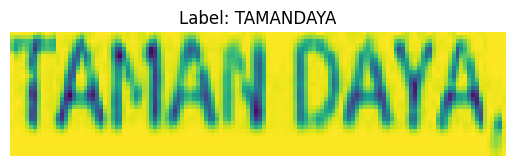

In [6]:
def show_sample(dataset, index):
    image, label = dataset[index]
    image_np = image.permute(1, 2, 0).numpy()  # Convert to HWC format
    image_np = (image_np * 0.5) + 0.5  # Unnormalize
    image_np = np.clip(image_np, 0, 1)
    label_text = ''.join([idx_to_char[idx.item()] for idx in label])

    plt.imshow(image_np)
    plt.title(f'Label: {label_text}')
    plt.axis('off')
    plt.show()

# Show a few samples from the training set
for idx in range(5):
    show_sample(train_dataset, idx)

In [7]:
def collate_fn(batch):
    images, labels = zip(*batch)

    max_width = max([img.size(2) for img in images])
    batch_size = len(images)
    channels = images[0].size(0)
    height = images[0].size(1)

    padded_images = torch.zeros(batch_size, channels, height, max_width)

    for i, img in enumerate(images):
        width = img.size(2)
        padded_images[i, :, :, :width] = img

    label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)

    labels = torch.cat(labels)

    return padded_images, labels, label_lengths

In [8]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [9]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.linear = nn.Linear(nHidden * 2, nOut)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        T, b, h = recurrent.size()
        output = self.linear(recurrent.view(T * b, h))
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh):
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(512, 512, 2, 1, 0), nn.BatchNorm2d(512), nn.ReLU(),
        )

        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass)
        )

    def forward(self, x):
        conv = self.cnn(x)
        b, c, h, w = conv.size()
        assert h == 1, 'Expected height of conv features to be 1'
        conv = conv.squeeze(2) 
        conv = conv.permute(2, 0, 1)  
        output = self.rnn(conv)
        return output


In [10]:
model = CRNN(imgH=32, nc=1, nclass=len(char_to_idx), nh=256)

criterion = CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def decode_predictions(outputs):
    outputs = outputs.permute(1, 0, 2)
    batch_size = outputs.size(0)
    _, preds = outputs.max(2)
    preds = preds.cpu().numpy()

    decoded_texts = []
    for i in range(batch_size):
        pred = preds[i]
        pred_text = ''
        prev_idx = -1
        for idx in pred:
            if idx != prev_idx and idx != 0:
                char = idx_to_char.get(idx, '')
                pred_text += char
            prev_idx = idx
        decoded_texts.append(pred_text)
    return decoded_texts


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [13]:
from tqdm import tqdm

def decode_predictions(outputs):
    # Greedy decoding
    outputs = outputs.permute(1, 0, 2)  # (T, N, C) -> (N, T, C)
    batch_size = outputs.size(0)
    _, preds = outputs.max(2)
    preds = preds.cpu().numpy()

    decoded_texts = []
    for i in range(batch_size):
        pred = preds[i]
        # Remove consecutive duplicates and blanks
        pred_text = ''
        prev_idx = -1
        for idx in pred:
            if idx != prev_idx and idx != 0:
                char = idx_to_char.get(idx, '')
                pred_text += char
            prev_idx = idx
        decoded_texts.append(pred_text)
    return decoded_texts

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct_samples = 0
        total_samples = 0

        # Wrap the data loader with tqdm
        progress_bar = tqdm(train_loader, leave=True)
        for images, labels, label_lengths in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            optimizer.zero_grad()

            outputs = model(images) 
            T, batch_size, nclass = outputs.size()

            input_lengths = torch.full(size=(batch_size,), fill_value=T, dtype=torch.long).to(device)

            outputs = outputs.log_softmax(2)
            loss = criterion(outputs, labels, input_lengths, label_lengths)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate accuracy
            with torch.no_grad():
                # Decode the outputs
                decoded_texts = decode_predictions(outputs)
                # Get ground truth texts
                labels_cpu = labels.cpu().numpy()
                label_lengths_cpu = label_lengths.cpu().numpy()

                idx = 0
                ground_truth_texts = []
                for length in label_lengths_cpu:
                    label_seq = labels_cpu[idx:idx+length]
                    text = ''.join([idx_to_char.get(l, '') for l in label_seq])
                    ground_truth_texts.append(text)
                    idx += length

                # Compare predictions with ground truth
                batch_correct = sum(pred_text == true_text for pred_text, true_text in zip(decoded_texts, ground_truth_texts))
                correct_samples += batch_correct
                total_samples += len(ground_truth_texts)

            # Update progress bar
            accuracy = 100.0 * correct_samples / total_samples if total_samples > 0 else 0.0
            avg_loss = epoch_loss / (total_samples / batch_size)  # Adjust if necessary

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=avg_loss, accuracy=f'{accuracy:.2f}%')

        avg_loss = epoch_loss / len(train_loader)
        epoch_accuracy = 100.0 * correct_samples / total_samples if total_samples > 0 else 0.0

        train_losses.append(avg_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


In [14]:
train_model(model, train_loader, criterion, optimizer)

Epoch 1/10: 100%|██████████| 263/263 [17:30<00:00,  4.00s/it, accuracy=1.15%, loss=2.58]


Epoch [1/10], Loss: 3.6626, Accuracy: 1.15%


Epoch 2/10: 100%|██████████| 263/263 [17:26<00:00,  3.98s/it, accuracy=8.98%, loss=1.6] 


Epoch [2/10], Loss: 2.2683, Accuracy: 8.98%


Epoch 3/10: 100%|██████████| 263/263 [17:13<00:00,  3.93s/it, accuracy=49.89%, loss=0.496]


Epoch [3/10], Loss: 0.7047, Accuracy: 49.89%


Epoch 4/10: 100%|██████████| 263/263 [17:15<00:00,  3.94s/it, accuracy=64.06%, loss=0.259]


Epoch [4/10], Loss: 0.3677, Accuracy: 64.06%


Epoch 5/10: 100%|██████████| 263/263 [17:13<00:00,  3.93s/it, accuracy=71.71%, loss=0.177]


Epoch [5/10], Loss: 0.2517, Accuracy: 71.71%


Epoch 6/10: 100%|██████████| 263/263 [17:27<00:00,  3.98s/it, accuracy=74.77%, loss=0.147]


Epoch [6/10], Loss: 0.2086, Accuracy: 74.77%


Epoch 7/10: 100%|██████████| 263/263 [17:30<00:00,  4.00s/it, accuracy=78.83%, loss=0.115]


Epoch [7/10], Loss: 0.1631, Accuracy: 78.83%


Epoch 8/10: 100%|██████████| 263/263 [17:25<00:00,  3.98s/it, accuracy=81.67%, loss=0.093]


Epoch [8/10], Loss: 0.1321, Accuracy: 81.67%


Epoch 9/10: 100%|██████████| 263/263 [17:24<00:00,  3.97s/it, accuracy=81.71%, loss=0.0928]


Epoch [9/10], Loss: 0.1319, Accuracy: 81.71%


Epoch 10/10: 100%|██████████| 263/263 [17:21<00:00,  3.96s/it, accuracy=83.94%, loss=0.0778]

Epoch [10/10], Loss: 0.1105, Accuracy: 83.94%


In [ ]:
torch.save(model.state_dict(), "./model_weights/receipts_ocr_model.pth")

In [16]:
model.eval()

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation

In [ ]:
def evaluate_model(model, test_loader):
    with torch.no_grad():
        total_samples = 0
        correct_samples = 0

        # Wrap the test_loader with tqdm to create a progress bar
        progress_bar = tqdm(test_loader, desc='Evaluating', leave=True)

        for images, labels, label_lengths in progress_bar:
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            outputs = outputs.log_softmax(2)

            # Decode predictions
            decoded_texts = decode_predictions(outputs)

            # Prepare ground truth texts
            labels_cpu = labels.cpu().numpy()
            label_lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            ground_truth_texts = []
            for length in label_lengths_cpu:
                label_seq = labels_cpu[idx:idx+length]
                text = ''.join([idx_to_char.get(l, '') for l in label_seq])
                ground_truth_texts.append(text)
                idx += length

            # Compare predictions with ground truth
            batch_correct = sum(pred_text == true_text for pred_text, true_text in zip(decoded_texts, ground_truth_texts))
            correct_samples += batch_correct
            total_samples += len(ground_truth_texts)

            # Update the progress bar with current accuracy
            accuracy = correct_samples / total_samples * 100 if total_samples > 0 else 0.0
            progress_bar.set_postfix({'Accuracy': f'{accuracy:.2f}%'})

        final_accuracy = correct_samples / total_samples * 100 if total_samples > 0 else 0.0
        print(f'Test Accuracy: {final_accuracy:.2f}%')
        return final_accuracy

test_accuracy = evaluate_model(model, test_loader)